### 라이브러리 불러오기

In [1]:
# library 불러오기
import pandas as pd
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# 동시 출력
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

#### 각 채널로 움직이는 전이 확률(Transition Probability) 구하기

- 유저가 여러 경로를 통해 제품을 접하고 구매하게 되는 기여도를 분배

In [2]:
# 데이터 가져오기
df = pd.read_csv('./data/attribution_data.csv')

# 데이터 보기
df.head()

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03T13:02:11Z,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17T19:15:07Z,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24T15:51:46Z,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29T07:44:51Z,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03T09:44:57Z,impression,0,0.0,Paid Search


In [13]:
# 유저 별로 접한 채널을 모두 list 로 묶는다.
df_paths = (
    df.groupby('cookie')['channel']
      .aggregate(
          lambda x: x.unique().tolist()
      )
      .reset_index()  
)

In [14]:
df_paths.head()

,cookie,channel
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search]
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search]
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [15]:
# 유저별 전환여부를 확인하고
# 마지막 row만 남기고 중복값을 제거한다
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_last_interaction.head(10)

,cookie,conversion
3,00000FkCnDfDDf0iC97iC703B,0
9,0000nACkD9nFkBBDECD3ki00E,0
14,0003EfE37E93D0BC03iBhBBhF,0
15,00073CFE3FoFCn70fBhB3kfon,0
16,00079hhBkDF3k3kDkiFi9EFAD,0
20,0007iiAiFh3ifoo9Ehn3ABB0F,0
21,0007o0nfoh9o79DDfD7DAiEnE,0
22,0007oEBhnoF97AoEE3BCkFnhB,1
23,00090n9EBBEkA000C7Cik999D,1
28,000A9AfDohfiBAFB0FDf3kDEE,0


In [16]:
# 기존에 만들어둔 path 데이터에 conversion 전환 여부를 합친다.
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

# path 데이터 확인
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


#### 마코브 체인 state 만들기

- 마코브 체인의 state 종류
    - Start: 첫 시작
    - Instagram: 인스타그램 광고
    - Paid Search: 유료 검색 광고
    - Facebook: 페이스북 광고
    - Online Video: 비디오형 광고
    - Online Display: 배너 노출 광고
    - Conversion: 전환 성공 (구매 완료)
    - Null: 전환 실패 (구매 없이 나감)

In [17]:
# 시작 State 와 최종 state를 추가한다
# 전환이 안되었다면 Null, 전환되었다면 Conversion State 를 캠페인 Path 뒤에 추가해준다. 
df_paths['paths'] = (
    df_paths
      .apply( 
          lambda x: ['Start'] + x.channel + ['Null'] 
            if x.conversion == 0 
            else ['Start'] + x.channel + ['Conversion'], 
          axis=1
      )
)

In [18]:
df_paths.head()

,cookie,channel,conversion,paths
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0,"[Start, Instagram, Online Display, Null]"
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0,"[Start, Paid Search, Null]"
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0,"[Start, Paid Search, Null]"
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,"[Start, Instagram, Null]"
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,"[Start, Paid Search, Null]"


In [20]:
# 총 쿠키수와 그 중 전환된 쿠키수 계산
cookie_count = len(df_paths)
conversion_count = len(df_paths.loc[df_paths.conversion == 1, :])
print('총 쿠키수:',cookie_count)
print('전환된 쿠키수:',conversion_count)

총 쿠키수: 240108
전환된 쿠키수: 17639


In [21]:
# 전체 데이터에서 전환된 쿠키수를 확인해보니
# 약 7% 정도로 알 수 있다
base_conversion_rate = conversion_count / cookie_count
print(base_conversion_rate)

0.07346277508454528


In [22]:
# transition 확률을 구하기 위한 데이터
list_of_paths = df_paths['paths']

In [25]:
# unique 한 상태(사건)
list_of_unique_channels = set(x for element in list_of_paths for x in element)
list_of_unique_channels

{'Conversion',
 'Facebook',
 'Instagram',
 'Null',
 'Online Display',
 'Online Video',
 'Paid Search',
 'Start'}

#### 마코브 체인은 현재와 그 다음 상태사이의 전이확률만 필요하다

- 따라서 과거의 상태는 필요하지 않다

In [35]:
# 전이 가능성이 있는 모든 상태를 count 하기 위해서 0으로 초기화 한다.
transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
transition_states

{'Conversion>Conversion': 0,
 'Conversion>Online Video': 0,
 'Conversion>Start': 0,
 'Conversion>Null': 0,
 'Conversion>Facebook': 0,
 'Conversion>Online Display': 0,
 'Conversion>Paid Search': 0,
 'Conversion>Instagram': 0,
 'Online Video>Conversion': 0,
 'Online Video>Online Video': 0,
 'Online Video>Start': 0,
 'Online Video>Null': 0,
 'Online Video>Facebook': 0,
 'Online Video>Online Display': 0,
 'Online Video>Paid Search': 0,
 'Online Video>Instagram': 0,
 'Start>Conversion': 0,
 'Start>Online Video': 0,
 'Start>Start': 0,
 'Start>Null': 0,
 'Start>Facebook': 0,
 'Start>Online Display': 0,
 'Start>Paid Search': 0,
 'Start>Instagram': 0,
 'Null>Conversion': 0,
 'Null>Online Video': 0,
 'Null>Start': 0,
 'Null>Null': 0,
 'Null>Facebook': 0,
 'Null>Online Display': 0,
 'Null>Paid Search': 0,
 'Null>Instagram': 0,
 'Facebook>Conversion': 0,
 'Facebook>Online Video': 0,
 'Facebook>Start': 0,
 'Facebook>Null': 0,
 'Facebook>Facebook': 0,
 'Facebook>Online Display': 0,
 'Facebook>Paid S

In [36]:
# Python for 문을 이용해서 각 상태에서 다음상태로 간 것이 몇 번 있었는지 구해보자

for possible_state in list_of_unique_channels: # 전체 가능한 상태를 돌면서
    if possible_state not in ['Conversion', 'Null']: # 마지막 상태인 전환/ 전환 안됨 상태를 제외하고
        for user_path in list_of_paths: # 유저 각각의 이동 경로를 돌면서
            # possible_state = "Paid Search"
            # user_path = ["start", "Paid Search", "Null"]
            if possible_state in user_path: # 그 이동경로에 possible_state 가 있다면

                # 그 state 가 발견된 list 의 index 를 가져와서
                indices = [i for i, s in enumerate(user_path) if possible_state in s] 
                for col in indices:
                    # 그 state 와 다음 state의 전이 관계에 1씩 더해준다.
                    key = user_path[col] + '>' + user_path[col + 1]
                    transition_states[key] += 1 

In [37]:
transition_states

{'Conversion>Conversion': 0,
 'Conversion>Online Video': 0,
 'Conversion>Start': 0,
 'Conversion>Null': 0,
 'Conversion>Facebook': 0,
 'Conversion>Online Display': 0,
 'Conversion>Paid Search': 0,
 'Conversion>Instagram': 0,
 'Online Video>Conversion': 3201,
 'Online Video>Online Video': 0,
 'Online Video>Start': 0,
 'Online Video>Null': 31285,
 'Online Video>Facebook': 2430,
 'Online Video>Online Display': 775,
 'Online Video>Paid Search': 1964,
 'Online Video>Instagram': 1307,
 'Start>Conversion': 0,
 'Start>Online Video': 34182,
 'Start>Start': 0,
 'Start>Null': 0,
 'Start>Facebook': 66848,
 'Start>Online Display': 34250,
 'Start>Paid Search': 76210,
 'Start>Instagram': 28618,
 'Null>Conversion': 0,
 'Null>Online Video': 0,
 'Null>Start': 0,
 'Null>Null': 0,
 'Null>Facebook': 0,
 'Null>Online Display': 0,
 'Null>Paid Search': 0,
 'Null>Instagram': 0,
 'Facebook>Conversion': 4690,
 'Facebook>Online Video': 2254,
 'Facebook>Start': 0,
 'Facebook>Null': 59319,
 'Facebook>Facebook': 0,


In [38]:
# 위에서 한 내용을 간결하게 함수로 정리하면
# 아래와 같은 함수가 하나 나온다
def transition_states(list_of_paths):

    # Unique한 State 를 구한다.
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}

    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

#### 확률로 정의해보자

- transition probability 로 정의하려면, 각 채널에서 다음 채널로 가는 수를 다 더해서 나눠준다.

In [ ]:
# 빈도수 행렬
"""
          Start, Facebook, Conversion, Null
Start    [[0,    100,      100      , 100 ],
Facebook. [0,     0,       100      , 100 ],
           ....]
"""
# Python Dictionary trans_states 에 빈도수를 계산해 놓은 상태입니다.
"""
{
    'Start>Start': 0,
    'Start>Facebook': 100,
    ...
    'Facebook>Start': 0,
    'Facebook>Conversion': 100
}
"""
# 전이 확률은? 
# Start 라는 현재 상태에서 다음상태로 가는 모든 빈도수를 다 더하면? 300
# Facebook 라는 현재 상태에서 다음상태로 가는 모든 빈도수를 다 더하면? 200
# P(X_n+1 = 'Start'|X_n = 'Start') 
# + P(X_n+1 = 'Facebook'|X_n = 'Start')
# + P(X_n+1 = 'Conversion'|X_n = 'Start')
# + P(X_n+1 = 'Null'|X_n = 'Start') = 1 
"""
          Start, Facebook, Conversion, Null
Start    [[0,    100/300,     100/300, 100/300 ], 
Facebook. [0,     0,          100/200, 100/200 ], # = 1
           ....]
"""
# Python Dictionary 에서 trans_prob 전이 확률을 구해보자

# Python Dictionary trans_states 에 빈도수를 계산해 놓은 상태입니다.
"""
{
    'Start>Start': 0,
    'Start>Facebook': 100,
    ...
    'Facebook>Start': 0,
    'Facebook>Conversion': 100
}
"""
# 1) Start> : Start 로 시작하는 모든 상태들의 빈도수를 다 더해준다.
# total = trans_states['Start>Start'] 
# + trans_states['Start>Facebook'] 
# + trans_states['Start>Conversion'] 
# + trans_states['Start>Null'] # = 전체 빈도수! 300

# 2) 각 빈도수 (Start 로 시작하는) 를 Start 로 시작하는 모든 상태들의 빈도수 총합으로 나눠주면 
# 우리는 전이 확률을 구할 수 있다.
# Start -> Start로 가는 전이확률! = trans_states['Start>Start']/total

In [39]:
# defaultdict를 활용한다
trans_prob = defaultdict(dict)

In [40]:
# 원래 dictionary 는 할당하지 않은 키를 조회하면 KeyError 가 발생한다. 
# tmp = {}
# tmp[0]
# defaultdict 는 에러 대신에 default 값을 반환한다.

tmp2 = defaultdict(int)
tmp2[1]

0

In [41]:
for state in list_of_unique_channels: 
    if state not in ['Conversion', 'Null']:
        

        # 1) trans_states 에서 각 채널에서 다른 채널로 가는 상태를 가져온다.
        # 예를 들어 Instagram에서 다른 채널로 가는 상태는 Instagram>Facebook, Instagram>Null.. 등이 있다.
        next_states_from_state = [s for s in trans_states if state + '>' in s]

        # 2) counter 라는 변수를 0으로 초기화한다.
        # counter: 그 State 에서 다른 State로 가는 모든 빈도수의 총합
        counter = 0

        # 3) 각 상태에서 다른 상태로 가는 모든 경우의 수에 해당하는 빈도수를 counter 에 다 더해줍니다.
        # Instagram> 에 해당하는 사건의 수를 counter에 다 더한다.
        # Instagram 에서 다른 State 로 가는 사건의 수를 구한 것이다.
        for next_state in next_states_from_state:
            # next_state = 'Instagram>Facebook'
            # trans_states[next_state] # Instagram -> Facebook 가는 빈도수
            if trans_states[next_state] > 0:
                counter += trans_states[next_state]

        # 앞에서 구한 counter 값으로 각 state 의 값을 나눠준다 
        for next_state in next_states_from_state:
            if trans_states[next_state] > 0:
                state_prob = float((trans_states[next_state])) / float(counter)
                trans_prob[next_state] = state_prob

In [42]:
trans_prob

defaultdict(dict,
            {'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Null': 0.7637566525072018,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Online Display': 0.018919974610614718,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Instagram': 0.03190762169815927,
             'Start>Online Video': 0.14236093757808985,
             'Start>Facebook': 0.2784080497109634,
             'Start>Online Display': 0.14264414346877238,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Instagram': 0.11918803205224315,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online Video': 0.025577304964539006,
             'Facebook>Null': 0.6731234042553191,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Instagram': 0.1730723404255319,
     

In [43]:
# 위와 같이 함수로 정리해보면

def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels: 
        if state not in ['Conversion', 'Null']:
            # trans_dict 에서 각 채널에서 다른 채널로 가는 상태를 가져온다.
            # 예를 들어 Instagram에서 다른 채널로 가는 상태는 Instagram>Facebook, Instagram>Null.. 등이 있다.
            next_states_from_state = [s for s in trans_dict if state + '>' in s]

            # counter 라는 변수를 0으로 초기화한다.
            counter = 0

            # Instagram> 에 해당하는 사건의 수를 counter에 다 더한다.
            # Instagram 에서 다른 State 로 가는 사건의 수를 구한 것이다.
            for next_state in next_states_from_state:
                state 
                if trans_dict[next_state] > 0:
                    counter += trans_dict[next_state]

            # 앞에서 구한 counter 값으로 각 state 의 값을 나눠준다 
            for next_state in next_states_from_state:
                if trans_dict[next_state] > 0:
                    state_prob = float((trans_dict[next_state])) / float(counter)
                    trans_prob[next_state] = state_prob
    return trans_prob


trans_prob = transition_prob(trans_states)

In [44]:
trans_prob

defaultdict(dict,
            {'Online Video>Conversion': 0.0781455983594551,
             'Online Video>Null': 0.7637566525072018,
             'Online Video>Facebook': 0.059323275230701626,
             'Online Video>Online Display': 0.018919974610614718,
             'Online Video>Paid Search': 0.04794687759386749,
             'Online Video>Instagram': 0.03190762169815927,
             'Start>Online Video': 0.14236093757808985,
             'Start>Facebook': 0.2784080497109634,
             'Start>Online Display': 0.14264414346877238,
             'Start>Paid Search': 0.31739883718993117,
             'Start>Instagram': 0.11918803205224315,
             'Facebook>Conversion': 0.053219858156028366,
             'Facebook>Online Video': 0.025577304964539006,
             'Facebook>Null': 0.6731234042553191,
             'Facebook>Online Display': 0.02435177304964539,
             'Facebook>Paid Search': 0.05065531914893617,
             'Facebook>Instagram': 0.1730723404255319,
     

### 전이확률행렬(Transition Probability Matrix)로 만들기

In [45]:
# list_of_unique_channels = set(x for element in list_of_paths for x in element)
trans_matrix = pd.DataFrame()

#
#          Start | Instagram | Facebook |
# Start     0.         0.5.       0.5
# Intagram.  0.33.    0.33        0.33
# Facebook. 

In [46]:
# Dataframe 의 index와 column에 채널을 추가하고
# Conversion과 Null 인 경우 그 다음 State 로 갈 수 없기 때문에, 각각 1을 부여한다
for channel in list_of_unique_channels:
    trans_matrix[channel] = 0.00
    trans_matrix.loc[channel] = 0.00

    # 자기 자신으로 가는 확률을 부여한다.
    trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0


In [47]:
# 전이행렬에 값을 입력한다
for key, value in trans_prob.items():
    origin, destination = key.split('>') # From, To 
    trans_matrix.at[origin, destination] = value

In [48]:
trans_matrix

,Conversion,Online Video,Start,Null,Facebook,Online Display,Paid Search,Instagram
Conversion,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.0,0.763757,0.059323,0.018920,0.047947,0.031908
Start,0.000000,0.142361,0.0,0.000000,0.278408,0.142644,0.317399,0.119188
Null,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
Facebook,0.053220,0.025577,0.0,0.673123,0.000000,0.024352,0.050655,0.173072
Online Display,0.050324,0.017299,0.0,0.756643,0.053986,0.000000,0.092386,0.029363
Paid Search,0.053309,0.029221,0.0,0.770779,0.064442,0.048053,0.000000,0.034196
Instagram,0.057979,0.024118,0.0,0.629786,0.218777,0.023531,0.045809,0.000000


In [49]:
# 이것도 깔끔하게 만들기 위해 함수를 사용해보자

def transition_matrix(list_of_paths, transition_probabilities):

    # 1) trans_matrix 초기화
    trans_matrix = pd.DataFrame()
    

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    # 2) trans_matrix 에 Transition Probability 를 각각 할당
    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

In [50]:
trans_matrix

,Conversion,Online Video,Start,Null,Facebook,Online Display,Paid Search,Instagram
Conversion,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.0,0.763757,0.059323,0.018920,0.047947,0.031908
Start,0.000000,0.142361,0.0,0.000000,0.278408,0.142644,0.317399,0.119188
Null,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
Facebook,0.053220,0.025577,0.0,0.673123,0.000000,0.024352,0.050655,0.173072
Online Display,0.050324,0.017299,0.0,0.756643,0.053986,0.000000,0.092386,0.029363
Paid Search,0.053309,0.029221,0.0,0.770779,0.064442,0.048053,0.000000,0.034196
Instagram,0.057979,0.024118,0.0,0.629786,0.218777,0.023531,0.045809,0.000000


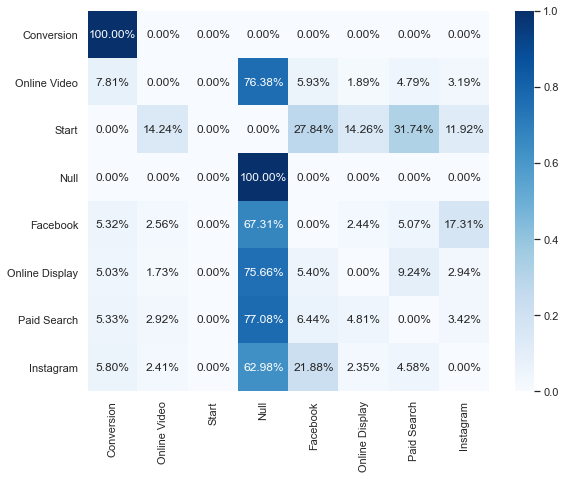

In [52]:
# 마지막으로 히트맵으로 시각화 확인
sns.set_theme(style="whitegrid", palette="pastel") # 테마를 설정한다
g = sns.heatmap(trans_matrix, annot=True, fmt='.2%', cmap="Blues")
g.figure.set_size_inches(9, 7) # 그래프의 크기를 키운다

### 각 채널의 Remove Effect 제거 효과를 구해보자

- 앞에서 구한 전이행렬로 각 채널의 기여도 분석

In [53]:
trans_matrix.head()

,Conversion,Online Video,Start,Null,Facebook,Online Display,Paid Search,Instagram
Conversion,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.0,0.763757,0.059323,0.018920,0.047947,0.031908
Start,0.000000,0.142361,0.0,0.000000,0.278408,0.142644,0.317399,0.119188
Null,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000
Facebook,0.053220,0.025577,0.0,0.673123,0.000000,0.024352,0.050655,0.173072


In [55]:
removal_effects_dict = {}
channels = [column for column in trans_matrix.columns if column not in ['Start','Null','Conversion']]
channels

['Online Video', 'Facebook', 'Online Display', 'Paid Search', 'Instagram']

Facebook 의 제거효과를 구해보자
- 목표: Facebook 으로 인한 전환이 다 없어졌다고 가정했을 때 전체 전환율을 구한다

- 1) Facebook 으로 인한 전환을 제거하는 일
- 2) 제거된 상태에서 전체 전환율을 다시 계산해보는 일 <- Absorbing Markov Chain 공식을 활용해 보려고 합니다

In [56]:
channel = 'Facebook'
removal_df = trans_matrix.drop(channel, axis=1).drop(channel, axis=0)
removal_df

,Conversion,Online Video,Start,Null,Online Display,Paid Search,Instagram
Conversion,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.0,0.763757,0.018920,0.047947,0.031908
Start,0.000000,0.142361,0.0,0.000000,0.142644,0.317399,0.119188
Null,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
Online Display,0.050324,0.017299,0.0,0.756643,0.000000,0.092386,0.029363
Paid Search,0.053309,0.029221,0.0,0.770779,0.048053,0.000000,0.034196
Instagram,0.057979,0.024118,0.0,0.629786,0.023531,0.045809,0.000000


In [57]:
# Facebook 으로 가던 전이 확률을 다 Null 로 가는 확률로 더해준다!
for column in removal_df.columns:

    # 각 전이행렬의 row 별 sum 을 구해서
    row_sum = np.sum(list(removal_df.loc[column]))

    # 1에서 빠진 부분만큼 Null 로 채워주자 
    null_pct = float(1) - row_sum
    print(column, row_sum, null_pct)
    if null_pct != 0:
        removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
    removal_df.loc['Null']['Null'] = 1.0

Conversion 1.0 0.0
Online Video 0.9406767247692984 0.05932327523070158
Start 0.7215919502890366 0.27840804971096345
Null 1.0 0.0
Online Display 0.9460144587362689 0.05398554126373112
Paid Search 0.9355583070688879 0.06444169293111213
Instagram 0.7812234666235394 0.21877653337646064


In [58]:
removal_df

,Conversion,Online Video,Start,Null,Online Display,Paid Search,Instagram
Conversion,1.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
Online Video,0.078146,0.000000,0.0,0.823080,0.018920,0.047947,0.031908
Start,0.000000,0.142361,0.0,0.278408,0.142644,0.317399,0.119188
Null,0.000000,0.000000,0.0,1.000000,0.000000,0.000000,0.000000
Online Display,0.050324,0.017299,0.0,0.810628,0.000000,0.092386,0.029363
Paid Search,0.053309,0.029221,0.0,0.835221,0.048053,0.000000,0.034196
Instagram,0.057979,0.024118,0.0,0.848563,0.023531,0.045809,0.000000


In [59]:
# Absorbing Markov Chain 공식 하나를 이용해서
# 맨 처음에 Start 에서 시작해서 어떤 State 를 다 거치고 오더라도
# 결과적으로 Conversion으로 가는 확률값 = Facebook 을 제거했을 때 Start에서 시작한 최종적인 전환율
# Abosorbing States : Null or Conversion
# Transient States: 변화하는 States 나머지 Start,... Channel 


removal_to_conv = removal_df[['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)


removal_to_non_conv = removal_df.drop(['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

In [60]:
# null, conversion 만 있는 dataframe 
removal_to_conv # = R

,Null,Conversion
Online Video,0.823080,0.078146
Start,0.278408,0.000000
Online Display,0.810628,0.050324
Paid Search,0.835221,0.053309
Instagram,0.848563,0.057979


In [61]:
# null, conversion 을 제거한 dataframe 
removal_to_non_conv # = Q

,Online Video,Start,Online Display,Paid Search,Instagram
Online Video,0.000000,0.0,0.018920,0.047947,0.031908
Start,0.142361,0.0,0.142644,0.317399,0.119188
Online Display,0.017299,0.0,0.000000,0.092386,0.029363
Paid Search,0.029221,0.0,0.048053,0.000000,0.034196
Instagram,0.024118,0.0,0.023531,0.045809,0.000000


In [62]:
# array형태로 보기
np.asarray(removal_to_non_conv)

array([[0.        , 0.        , 0.01891997, 0.04794688, 0.03190762],
       [0.14236094, 0.        , 0.14264414, 0.31739884, 0.11918803],
       [0.01729885, 0.        , 0.        , 0.09238569, 0.02936344],
       [0.02922107, 0.        , 0.04805268, 0.        , 0.03419631],
       [0.02411758, 0.        , 0.02353131, 0.04580924, 0.        ]])

Identity Matrix(단위 행렬): 단위행렬은 주대각선의 원소가 1이고, 나머지는 모두 0인 정사각행렬

In [63]:
I = np.identity(len(removal_to_non_conv.columns))
print(I)

Q = np.asarray(removal_to_non_conv)
print(Q)

[[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
[[0.         0.         0.01891997 0.04794688 0.03190762]
 [0.14236094 0.         0.14264414 0.31739884 0.11918803]
 [0.01729885 0.         0.         0.09238569 0.02936344]
 [0.02922107 0.         0.04805268 0.         0.03419631]
 [0.02411758 0.         0.02353131 0.04580924 0.        ]]


In [64]:
mat = I - Q
mat

# 역행렬을 구한다 
# F
removal_inv_diff = np.linalg.inv(mat)
F = np.linalg.inv(I - Q)
removal_inv_diff # = F



array([[ 1.        ,  0.        , -0.01891997, -0.04794688, -0.03190762],
       [-0.14236094,  1.        , -0.14264414, -0.31739884, -0.11918803],
       [-0.01729885,  0.        ,  1.        , -0.09238569, -0.02936344],
       [-0.02922107,  0.        , -0.04805268,  1.        , -0.03419631],
       [-0.02411758,  0.        , -0.02353131, -0.04580924,  1.        ]])

array([[1.00272629, 0.        , 0.02226629, 0.05171129, 0.03441676],
       [0.15875911, 1.        , 0.16562845, 0.34677051, 0.14097535],
       [0.02099524, 0.        , 1.0057718 , 0.09545869, 0.03346716],
       [0.03120237, 0.        , 0.04988651, 1.00779629, 0.03692335],
       [0.02610673, 0.        , 0.0264894 , 0.0496598 , 1.00330901]])

In [66]:
# 5*5 x 5*2 F X R

# 앞의 Matrix 는 흡수 상태를 고려하여 구한 고정된 Matrix 
# 뒤의 Matrix 는 각 채널에서 전환으로 가는 확률에 대한 Matrix
removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
removal_dot_prod # 5 x 2

array([[0.91576868, 0.08423132],
       [0.95259886, 0.04740114],
       [0.9407157 , 0.0592843 ],
       [0.93918547, 0.06081453],
       [0.93580842, 0.06419158]])

In [67]:
pd.DataFrame(removal_dot_prod, index=removal_to_conv.index, columns = removal_to_conv.columns)# [[1]]

# 0(Null ), 1

# 우리가 이 matrix, Dataframe 에서 알 수 있는 것은
# Start -> Conversion : 0.047401 4.7%

,Null,Conversion
Online Video,0.915769,0.084231
Start,0.952599,0.047401
Online Display,0.940716,0.059284
Paid Search,0.939185,0.060815
Instagram,0.935808,0.064192


In [68]:
# Start -> Conversion 로 가는 확률, 즉 Facebook 제거 후 총 전환율을 가져온다.
removal_cvr = pd.DataFrame(removal_dot_prod,index=removal_to_conv.index)[[1]].loc['Start'].values[0]

In [69]:
# Facebook 을 제거하니 Start -> Conversion, 즉 총 전환율은 다음과 같다.
removal_cvr

# 원래의 전환율은 다음과 같았다.
base_conversion_rate

# 전체 전환율 중 Facebook 을 제거한 전환율의 비중은 다음과 같다.
removal_cvr / base_conversion_rate

# 아 전환율의 35%가 사라질 수 있다 (하지만 모든 채널의 효과를 구해서 다시 비중을 조정해야 한다.)
removal_effect = 1 - removal_cvr / base_conversion_rate
removal_effect

0.04740113808165116

0.07346277508454528

0.6452402325817279

0.3547597674182721

In [70]:
# 전과 같이 함수로 만들어서 표현한다
# 모든 채널의 removal effect를 구하자

def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = removal_df.loc[column]['Null'] + null_pct
            removal_df.loc['Null']['Null'] = 1.0

        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        # removal_effects_dict
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [71]:
removal_effects_dict

{'Online Video': 0.2069141165564219,
 'Facebook': 0.3547597674182721,
 'Online Display': 0.15435482356041286,
 'Paid Search': 0.3311037560086154,
 'Instagram': 0.21731366149038445}

전체 전환수에 대한 각 채널의 기여도를 구한다

In [72]:
# 전체 확률을 다 더해준다.
re_sum = np.sum(list(removal_effects_dict.values()))
re_sum

1.2644461250341066

In [73]:
conversion_count

17639

In [74]:
for k, v in removal_effects_dict.items():

  # 앞에서 구한 확률을 전체 확률로 나누고, 총 전환수에 곱한다.
  # 의미: 각 제거 효과로 구한 확률의 비중만큼 전환에 대한 기여도를 재조정한다.
  print(k, (v / re_sum) * conversion_count)

Online Video 2886.4480895461475
Facebook 4948.892177847523
Online Display 2153.2469267590836
Paid Search 4618.891257291356
Instagram 3031.5215485558915


In [75]:
# 역시 함수로 정리해보자
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, conversion_count)

In [76]:
attributions

{'Online Video': 2886.4480895461475,
 'Facebook': 4948.892177847523,
 'Online Display': 2153.2469267590836,
 'Paid Search': 4618.891257291356,
 'Instagram': 3031.5215485558915}

In [77]:
# 보기 쉽게 데이터 프레임으로 변환
attribution_by_markov = pd.DataFrame({'channel': attributions.keys(), 'attribution': attributions.values()})
attribution_by_markov

,channel,attribution
0,Online Video,2886.448090
1,Facebook,4948.892178
2,Online Display,2153.246927
3,Paid Search,4618.891257
4,Instagram,3031.521549


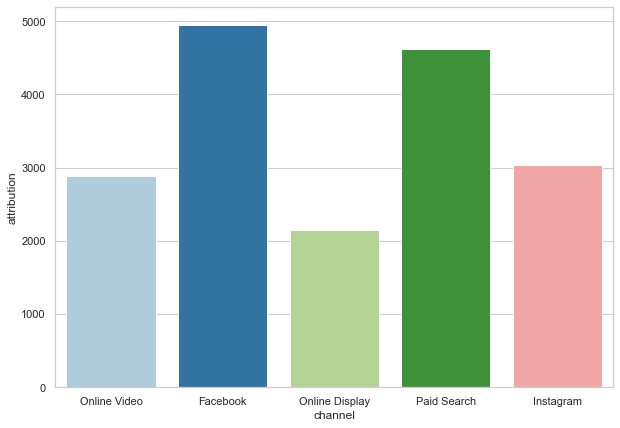

In [78]:
# 시각화
sns.set_theme(style="whitegrid", palette="Paired") # 테마를 설정한다
g = sns.barplot(x=attribution_by_markov.channel, y=attribution_by_markov.attribution, data = attribution_by_markov)
g.figure.set_size_inches(10, 7)

### 간단한 기여도 모델과 Markov Chain 모델로 구한 기여도 비교하기

In [79]:
attribution_by_markov["method"] = "markov"

In [80]:
# 앞에서 작업했던 데이터를 불러온다
total_data = pd.read_csv('total_data.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'total_data.csv'

In [ ]:
# 앞에서 그래프 그릴 때 사용했던 데이터에 markov 모델도 더해준다.
total_with_markov = total_data.append(attribution_by_markov, ignore_index = True)

In [ ]:
# 다른 모델에서 낮아보였던 Instagram의 기여도는 높아졌다.
sns.set_theme(style="whitegrid", palette="Paired") # 테마를 설정한다
g = sns.barplot(x=total_with_markov.channel, y=total_with_markov.attribution, hue = total_with_markov.method)
g.figure.set_size_inches(10, 7)